In [2]:
%matplotlib inline
from imageio import imread
import matplotlib.pyplot as plt
from TerrainMesh.utils.semantic_labels import convert_class_to_rgb_sensat_simplified 
from TerrainMesh.vis.vis import pseudo_color_map, pseudo_color_map_sparse

import torch
import torch.nn as nn
from torchvision import transforms
from TerrainMesh.config import get_sensat_cfg

import plotly.graph_objects as go
import numpy as np 
from TerrainMesh.mesh_init.mesh_init_linear_solver import init_mesh_sparse
from TerrainMesh.mesh_init.mesh_renderer import mesh_render_depth
from pytorch3d.structures import Meshes
from TerrainMesh.vis.vis import texture_mesh_vertices

import os
from pytorch3d.structures import Meshes
from scipy import ndimage
from TerrainMesh.model.models import VoxMeshHead

from TerrainMesh.mesh_init.mesh_renderer import render_mesh_texture

import meshplot as mp
import cv2
from skimage.transform import resize
import random
import trimesh

# ========================
# ESANet
# ========================

import argparse
from glob import glob
import os
from ESANet.src.args import ArgumentParserRGBDSegmentation
from ESANet.src.build_model import build_model
from ESANet.src.prepare_data import prepare_data

import torch.nn.functional as F

import open3d as o3d
from TerrainMesh.vis.vis import texture_mesh

# ========================
# FUNCTION DEFINITIONS
# ========================

def rescale_mesh(mesh, original_min, original_max):
    z_vals = np.asarray(mesh.vertices)[:,2]
    z_vals_scaled = ((z_vals - np.min(z_vals)) / (np.max(z_vals) - np.min(z_vals))) * (original_max - original_min) + original_min
    vertices_scaled = np.asarray(mesh.vertices).copy()
    vertices_scaled[:,2] = z_vals_scaled
    mesh.vertices = o3d.utility.Vector3dVector(vertices_scaled)
    return mesh

def make_mesh(vertices, faces, smooth=True, its=5):
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    if smooth:
        mesh = mesh.filter_smooth_simple(number_of_iterations=its)
    return mesh


def export_obj(vertices, faces, filepath):
    with open(filepath, 'w') as f:
        # Write vertices
        x_max = float('-inf')
        x_min = float('inf')
        y_max = float('-inf')
        y_min = float('inf')
        for vertex in vertices:
            f.write(f"v {' '.join(map(str, vertex))}\n")
            x_max = max(x_max, vertex[0])
            x_min = min(x_min, vertex[0])
            y_max = max(y_max, vertex[1])
            y_min = min(y_min, vertex[1])

        # Write faces
        for face in faces:
            f.write("f")
            for vertex_index in face:
                vi = vertex_index + 1
                f.write(f" {vi}")  # OBJ format indices are 1-based
            f.write("\n")

# Get the unique colors
CLASS_NAMES_13 = ['void',
                      'bed', 'books', 'ceiling', 'chair', 'floor', 'furniture',
                      'objects', 'picture', 'sofa', 'table', 'tv', 'wall',
                      'window']
CLASS_NAMES_40 = ['void',
                  'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa',
                  'table', 'door', 'window', 'bookshelf', 'picture',
                  'counter', 'blinds', 'desk', 'shelves', 'curtain',
                  'dresser', 'pillow', 'mirror', 'floor mat', 'clothes',
                  'ceiling', 'books', 'refridgerator', 'television',
                  'paper', 'towel', 'shower curtain', 'box', 'whiteboard',
                  'person', 'night stand', 'toilet', 'sink', 'lamp',
                  'bathtub', 'bag',
                  'otherstructure', 'otherfurniture', 'otherprop']

CLASS_NAMES_5 = ['wall', 'floor', 'furniture', 'objects', 'ceiling']

CLASS_13_TO_5_MAP = {
    'void': 'wall',
    'bed': 'furniture',
    'books': 'objects',
    'ceiling': 'ceiling',
    'chair': 'furniture',
    'floor': 'floor',
    'furniture': 'furniture',
    'objects': 'objects',
    'picture': 'objects',
    'sofa': 'furniture',
    'table': 'furniture',
    'tv': 'furniture',
    'wall': 'wall',
    'window': 'wall',
}

CLASS_13_TO_IDX_MAP = {}
for idx, c in enumerate(CLASS_NAMES_13):
    CLASS_13_TO_IDX_MAP[c] = idx

CLASS_5_TO_IDX_MAP = {}
for idx, c in enumerate(CLASS_NAMES_5):
    CLASS_5_TO_IDX_MAP[c] = idx

CLASS_40_TO_13_MAP = {
    'void': 'void',
    'wall': 'wall',
    'floor': 'floor',
    'cabinet': 'furniture',
    'bed': 'bed',
    'chair': 'chair',
    'sofa': 'sofa',
    'table': 'table',
    'door': 'wall',
    'window': 'window',
    'bookshelf': 'furniture',
    'picture': 'picture',
    'counter': 'furniture',
    'blinds': 'wall',
    'desk': 'table',
    'shelves': 'furniture',
    'curtain': 'wall',
    'dresser': 'furniture',
    'pillow': 'objects',
    'mirror': 'objects',
    'floor mat': 'floor',
    'clothes': 'objects',
    'ceiling': 'ceiling',
    'books': 'books',
    'refridgerator': 'furniture',
    'television': 'tv',
    'paper': 'objects',
    'towel': 'objects',
    'shower curtain': 'objects',
    'box': 'objects',
    'whiteboard': 'objects',
    'person': 'objects',
    'night stand': 'furniture',
    'toilet': 'furniture',
    'sink': 'furniture',
    'lamp': 'objects',
    'bathtub': 'furniture',
    'bag': 'objects',
    'otherstructure': 'wall',
    'otherfurniture': 'furniture',
    'otherprop': 'objects',
}

CLASS_40_13_IDX_MAP = []
for c in CLASS_NAMES_40:
    CLASS_40_13_IDX_MAP.append(CLASS_13_TO_IDX_MAP[CLASS_40_TO_13_MAP[c]])
# CLASS_40_13_IDX_MAP = np.array(CLASS_40_13_IDX_MAP)
# print(CLASS_40_13_IDX_MAP)
CLASS_40_13_IDX_MAP = torch.tensor(CLASS_40_13_IDX_MAP)

CLASS_13_5_IDX_MAP = []
for c in CLASS_NAMES_13:
    CLASS_13_5_IDX_MAP.append(CLASS_5_TO_IDX_MAP[CLASS_13_TO_5_MAP[c]])
# CLASS_13_5_IDX_MAP = np.array(CLASS_13_5_IDX_MAP)
# print(CLASS_13_5_IDX_MAP)
CLASS_13_5_IDX_MAP = torch.tensor(CLASS_13_5_IDX_MAP)

def class_to_rgb_indoor(img_class):
    class_color_map = {
        0:(51, 158, 133), #wall 
        1:(200,200,200), #floor
        2:(179, 245, 229), #furniture
        3:(247, 52, 143), #objects
        4:(114, 192, 247), #ceiling
    }
    h, w = img_class.shape
    img_rgb = np.zeros((h,w,3))
    for classlabel, color in class_color_map.items():
        binary_mask = (img_class == classlabel)
        img_rgb[binary_mask,:] = color 
    return img_rgb.astype(np.uint8)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Model Initialization

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

parser = ArgumentParserRGBDSegmentation(
    description='Efficient RGBD Indoor Sematic Segmentation (Inference)',
    formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.set_common_args()
parser.add_argument('--ckpt_path', type=str,
                    default="ESANet/trained_models/scenenet/r34_NBt1D_scenenet.pth",
                    help='Path to the checkpoint of the trained model.')
parser.add_argument('--depth_scale', type=float,
                    default=1.0,
                    help='Additional depth scaling factor to apply.')
args, _ = parser.parse_known_args()

args.pretrained_on_imagenet = False  # we are loading other weights anyway
dataset, preprocessor = prepare_data(args, with_input_orig=True)

n_classes = dataset.n_classes_without_void

model_semantic, _ = build_model(args, n_classes=n_classes)
checkpoint = torch.load(args.ckpt_path,
                        map_location=lambda storage, loc: storage)
model_semantic.load_state_dict(checkpoint['state_dict'])

model_semantic.eval()
model_semantic.to(device)


save_model_path = "TerrainMesh/checkpoints/Sem_Dice/model_best_depth.tar"
# device = torch.device("cuda:0")

# Load a trained 2D-3D model for mesh refinement
cfg = get_sensat_cfg()
cfg.merge_from_file(os.path.join(save_model_path,"..","Sensat_basic.yaml"))
model = VoxMeshHead(cfg)
checkpoint = torch.load(save_model_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

Loaded NYUv2 dataset without files
Loaded NYUv2 dataset without files


/oscar/home/nxu4/computer_vision/ESANet/src/build_model.py:29: UserWarning: Argument --channels_decoder is ignored when --decoder_chanels_mode decreasing is set.
  warnings.warn('Argument --channels_decoder is ignored when '
/oscar/home/nxu4/computer_vision/ESANet/src/models/resnet.py:101: UserWarning: parameters groups, base_width and norm_layer are ignored in NonBottleneck1D
  warnings.warn('parameters groups, base_width and norm_layer are '
/oscar/home/nxu4/computer_vision/ESANet/src/models/model.py:162: UserWarning: for the context module the learned upsampling is not possible as the feature maps are not upscaled by the factor 2. We will use nearest neighbor instead.
  warnings.warn('for the context module the learned upsampling is '


Device: cuda:0
ESANet(
  (activation): ReLU(inplace=True)
  (encoder_rgb): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): NonBottleneck1D(
        (conv3x1_1): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
        (conv1x3_1): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        (bn1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
        (conv3x1_2): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
        (conv1x3_2): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        (bn2): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_st

/users/nxu4/.conda/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/nxu4/.conda/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VoxMeshHead(
  (backbone): ResNetBackbone(
    (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (stem): Sequential(
      (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (stage1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3,

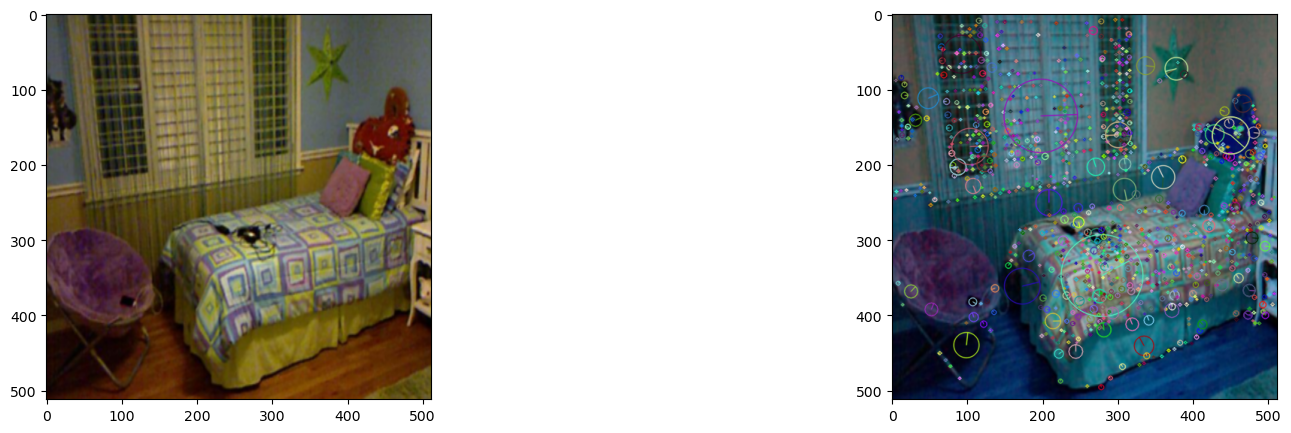

In [41]:
n = 402
nyu_rgb = np.load(f"nyuv2_dataset/rgb/{n}.npy")

gray = cv2.cvtColor(nyu_rgb, cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
keypoints = sift.detect(gray, None)
keypoint_locations = [kp.pt for kp in keypoints]

image_with_keypoints = cv2.drawKeypoints(nyu_rgb, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image_with_keypoints_rgb = cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))

ax1.imshow(nyu_rgb)
ax2.imshow(image_with_keypoints_rgb, cmap='gray')

# Pipeline

In [36]:
depth_scale = 1.0
depth_min = 50
depth_max = 600

nyu_rgb = np.load(f"nyuv2_dataset/rgb/{n}.npy")
nyu_sparse_depth = np.load(f"nyuv2_dataset/sparse_depth/{n}.npy")
nyu_depth = np.load(f"nyuv2_dataset/gt_depth/{n}.npy")
nyu_label = np.load(f"nyuv2_dataset/semantic/{n}.npy").astype(int)

rgb = nyu_rgb

sparsedepth = np.squeeze(nyu_sparse_depth)/.01
nonzero_indices = sparsedepth != 0
nonzero_values = sparsedepth[nonzero_indices]
mapped_values = ((nonzero_values - np.min(nonzero_values)) / (np.max(nonzero_values) - np.min(nonzero_values))) * (300-250) + 250
sparsedepth[nonzero_indices] = mapped_values

gt_depth = np.squeeze(nyu_depth)/.01

nyu_label_5 = np.vectorize(lambda idx: CLASS_5_TO_IDX_MAP[CLASS_13_TO_5_MAP[CLASS_NAMES_13[idx]]])(nyu_label + 1)
gt_sem_vis = class_to_rgb_indoor(nyu_label_5)

sparsedepth_vis = pseudo_color_map_sparse(sparsedepth,depth_min,depth_max)
gt_depth_vis = pseudo_color_map(gt_depth,depth_min,depth_max)

original_max = np.max(nonzero_values)
original_min = np.min(nonzero_values)

# =================================
# MESH INITIALIZATION
# =================================

num_mesh_vertices = 1024
image_size = 512
focal_length = -2


# Initialize the mesh using only the sparse depth
init_mesh_vertices, init_mesh_faces = init_mesh_sparse(sparsedepth,num_mesh_vertices,w_laplacian=0.5)
init_mesh_vertices_tensor = torch.tensor(init_mesh_vertices,dtype=torch.float32,device=device)
init_mesh_faces_tensor = torch.tensor(init_mesh_faces,dtype=torch.int32,device=device)
init_mesh = Meshes(verts=[init_mesh_vertices_tensor], faces=[init_mesh_faces_tensor])

init_mesh_depth = mesh_render_depth(init_mesh,image_size=image_size,focal_length=focal_length)

print(init_mesh_depth)

init_mesh_depth_vis = pseudo_color_map(init_mesh_depth,depth_min,depth_max)

init_mesh_height_color = texture_mesh_vertices(init_mesh_vertices, depth_min, depth_max)
rotate_matrix = np.array([[1,0,0],[0,-np.sqrt(3)/2,1/2],[0,-1/2,-np.sqrt(3)/2]])

# =================================
# SEMANTIC SEGMENTATION
# =================================
h, w, _ = rgb.shape

# init_mesh_mapped = ((init_mesh_depth - np.min(init_mesh_depth)) / (np.max(init_mesh_depth) - np.min(init_mesh_depth))) * (original_max - original_min) + original_min

# preprocess sample
sample = preprocessor({'image': rgb, 'depth': init_mesh_depth})

# add batch axis and copy to device
image = sample['image'][None].to(device)
depth = sample['depth'][None].to(device)

# apply network
pred = model_semantic(image, depth)
pred_semantic_weights = F.interpolate(pred, (h, w),
                     mode='bilinear', align_corners=False)

pred_semantic = torch.argmax(pred_semantic_weights, dim=1)
pred_semantic = pred_semantic.cpu().numpy().squeeze().astype(np.uint8)

pred_semantic = np.vectorize(lambda idx: CLASS_5_TO_IDX_MAP[CLASS_13_TO_5_MAP[CLASS_40_TO_13_MAP[CLASS_NAMES_40[idx]]]])(pred_semantic+1)
# print("semantic image shape", pred_semantic.shape)
print("UNIQUE", np.unique(pred_semantic))
pred_semantic_features = F.one_hot(torch.tensor(pred_semantic+1), num_classes=5)


# Add batch dimension to the one-hot tensor
pred_semantic_features = pred_semantic_features.unsqueeze(0).permute(0, 3, 1, 2).to(torch.float32) * 5
# pred_semantic_features =  F.interpolate(pred_semantic_features, (h, w), mode='bilinear', align_corners=False)
# print("semantic one hot shape", pred_semantic_features.shape)
# print(pred_semantic_features)
pred_semantic_features = pred_semantic_features.to(device)
pred_semantic_vis = class_to_rgb_indoor(pred_semantic)
plt.imsave("output/semantic_texture.png", pred_semantic_vis)

# =================================
# MESH REFINEMENT
# =================================

# Combine the 2D inputs, including the RGB, the initial mesh rendered depth and the sparse depth EDT.
rgb_tensor = transforms.ToTensor()(rgb).unsqueeze(0).to(device)
init_mesh_depth_tensor = transforms.ToTensor()(init_mesh_depth/depth_scale).unsqueeze(0).to(device)
sparsedepth_mask = (sparsedepth<=0)*1
depth_edt = ndimage.distance_transform_edt(sparsedepth_mask)
depth_edt_tensor = transforms.ToTensor()(depth_edt).unsqueeze(0).to(device)
input_img = torch.cat((rgb_tensor, init_mesh_depth_tensor, depth_edt_tensor), dim=1).to(torch.float)

# Normalized the mesh
init_mesh_scale = torch.mean(init_mesh_vertices_tensor[:,2])
init_mesh_vertices_norm_tensor = init_mesh_vertices_tensor / init_mesh_scale
init_mesh = Meshes(verts=[init_mesh_vertices_norm_tensor], faces=[init_mesh_faces_tensor])

# The model takes in the concatenated 2D inputs, the initial mesh and the 2D semantic segmentation
refine_mesh = model(input_img, init_mesh, pred_semantic_features)
refine_mesh = refine_mesh[1].scale_verts(init_mesh_scale.unsqueeze(0).to(device))

refine_mesh_semantic, refine_mesh_depth = render_mesh_texture(refine_mesh,image_size=image_size,focal_length=focal_length,device=device)
refine_mesh_semantic = np.vectorize(lambda idx: CLASS_5_TO_IDX_MAP[CLASS_13_TO_5_MAP[CLASS_40_TO_13_MAP[CLASS_NAMES_40[idx]]]])(refine_mesh_semantic)
refine_mesh_semantic_vis = class_to_rgb_indoor(refine_mesh_semantic)
refine_mesh_depth_vis = pseudo_color_map(refine_mesh_depth,depth_min,depth_max)

refine_mesh_vertices, refine_mesh_faces = refine_mesh.get_mesh_verts_faces(0)
refine_mesh_vertices = refine_mesh_vertices.detach().cpu().numpy()
refine_mesh_faces = refine_mesh_faces.detach().cpu().numpy()
refine_mesh_height_color = texture_mesh_vertices(refine_mesh_vertices, depth_min, depth_max)
rotate_matrix = np.array([[1,0,0],[0,-np.sqrt(3)/2,1/2],[0,-1/2,-np.sqrt(3)/2]])

# export_obj(refine_mesh_vertices, refine_mesh_faces, "tmp/out.obj")
# mesh = trimesh.load_mesh("tmp/out.obj")
# smoothed_mesh = trimesh.smoothing.filter_laplacian(mesh, iterations=5)
# # smoothed_mesh.export("tmp/denoised.obj")

# original_max = np.max(nonzero_values)
# original_min = np.min(nonzero_values)
# print(original_max, original_min)

# new_vertices = smoothed_mesh.vertices.copy()
# print(smoothed_mesh.vertices)
# z_vals = new_vertices[:,2]
# z_vals_scaled = ((z_vals - np.min(z_vals)) / (np.max(z_vals) - np.min(z_vals))) * (original_max - original_min) + original_min
# new_vertices[:,2] = z_vals_scaled
# print(z_vals_scaled)
# export_obj(new_vertices, refine_mesh_faces, "output/denoised-mapped.obj")

# refine_mesh_depth_vis = pseudo_color_map(refine_mesh_depth,depth_min,depth_max)

[[293.88766 293.87888 293.87003 ... 273.0725  273.07184 273.06366]
 [293.89197 293.89304 293.88425 ... 273.07266 273.06445 273.05627]
 [293.89584 293.89703 293.89844 ... 273.06528 273.0571  273.0489 ]
 ...
 [284.74646 284.75247 284.73352 ... 270.51227 270.51974 270.52643]
 [284.72208 284.7031  284.6841  ... 270.51974 270.54987 270.5552 ]
 [284.67267 284.6537  284.63467 ... 270.5264  270.55518 270.58743]]
UNIQUE [0 2 3]


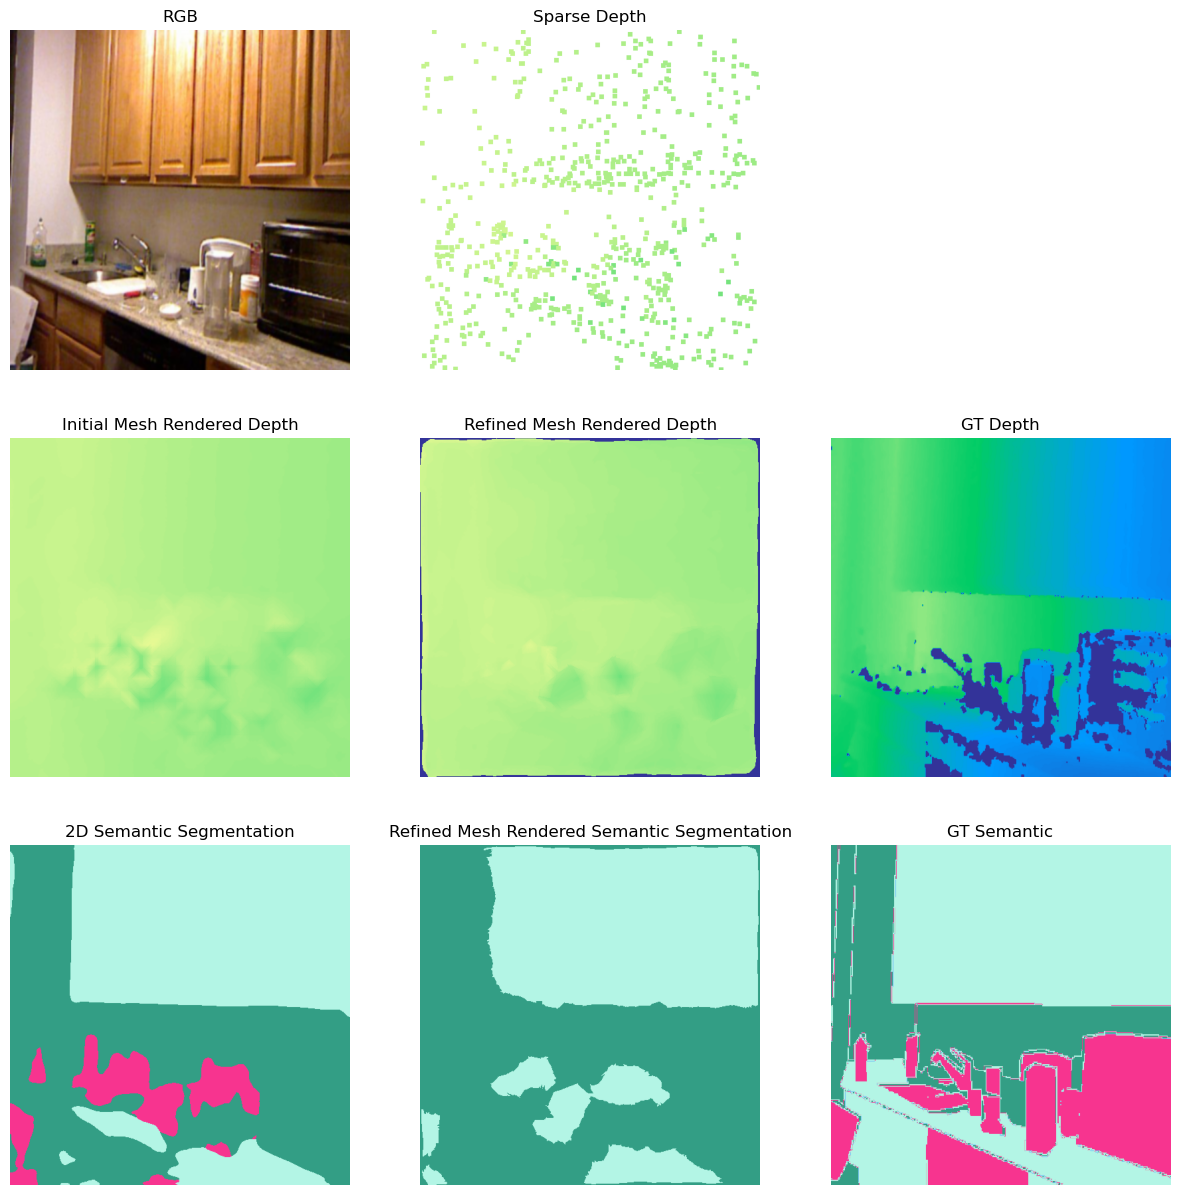

In [37]:
# =================================
# VISUALIZATION
# =================================

fig, ((ax11,ax12,ax13),(ax21,ax22,ax23),(ax31,ax32,ax33)) = plt.subplots(3,3,figsize=(15,15))

ax11.imshow(rgb)
ax11.set_title('RGB')
ax11.axis('off')
ax12.imshow(sparsedepth_vis)
ax12.set_title('Sparse Depth')
ax12.axis('off')
ax13.axis('off')

ax21.imshow(init_mesh_depth_vis)
ax21.set_title('Initial Mesh Rendered Depth')
ax21.axis('off')
ax22.imshow(refine_mesh_depth_vis)
ax22.set_title('Refined Mesh Rendered Depth')
ax22.axis('off')
ax23.imshow(gt_depth_vis)
ax23.set_title('GT Depth')
ax23.axis('off')

ax31.imshow(pred_semantic_vis)
ax31.set_title('2D Semantic Segmentation')
ax31.axis('off')
ax32.imshow(refine_mesh_semantic_vis)
ax32.set_title('Refined Mesh Rendered Semantic Segmentation')
ax32.axis('off')
ax33.imshow(gt_sem_vis)
ax33.set_title('GT Semantic')
ax33.axis('off')

plt.show()

In [191]:
original_max = np.max(nonzero_values)
original_min = np.min(nonzero_values)

refined_mesh = make_mesh(refine_mesh_vertices, refine_mesh_faces, its=7)
refined_mesh = rescale_mesh(refined_mesh, original_min, original_max)

new_vertices = np.asarray(refined_mesh.vertices)

refine_mesh_height_color = texture_mesh_vertices(new_vertices, 100, depth_max)
rotate_matrix = np.array([[1,0,0],[0,-np.sqrt(3)/2,1/2],[0,-1/2,-np.sqrt(3)/2]])
mp.plot(new_vertices@rotate_matrix, refine_mesh_faces, refine_mesh_height_color)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-3.554168…

In [192]:


focal_length_texture = 2
refine_mesh_rgb_path = "output/refined_mesh/refine_rgb.obj"
refine_mesh_depth_path = "output/refined_mesh/refine_depth.obj"
refine_mesh_semantic_path = "output/refined_mesh/refine_semantic.obj"

# Save the mesh in the Open3D TriangleMesh
# refine_mesh_o3d = o3d.geometry.TriangleMesh()
# refine_mesh_o3d.vertices = o3d.utility.Vector3dVector(refine_mesh_vertices)
# refine_mesh_o3d.triangles = o3d.utility.Vector3iVector(refine_mesh_faces)
# refine_mesh_o3d = refine_mesh_o3d.filter_smooth_simple(number_of_iterations=2)

# refine_mesh_o3d.compute_vertex_normals()
original_max = np.max(nonzero_values)/2
original_min = np.min(nonzero_values)

# RGB colors
refine_mesh_rgb = make_mesh(refine_mesh_vertices, refine_mesh_faces)
refine_mesh_rgb = texture_mesh(rgb, refine_mesh_rgb, focal_length_texture)
refine_mesh_rgb = rescale_mesh(refine_mesh_rgb, original_min, original_max)
o3d.io.write_triangle_mesh(refine_mesh_rgb_path,refine_mesh_rgb)

# # Elevation/Depth
refine_mesh_depth = make_mesh(refine_mesh_vertices, refine_mesh_faces, smooth=False)
refine_mesh_depth = texture_mesh(refine_mesh_depth_vis, refine_mesh_depth, focal_length_texture)
refine_mesh_depth = rescale_mesh(refine_mesh_depth, original_min, original_max)
o3d.io.write_triangle_mesh(refine_mesh_depth_path,refine_mesh_depth)

# # Semantic
refine_mesh_semantic = make_mesh(refine_mesh_vertices, refine_mesh_faces, its=5)
refine_mesh_semantic = texture_mesh(pred_semantic_vis, refine_mesh_semantic, focal_length_texture)
refine_mesh_semantic = rescale_mesh(refine_mesh_semantic, original_min, original_max)
o3d.io.write_triangle_mesh(refine_mesh_semantic_path,refine_mesh_semantic)

True

array([[-148.33255108, -145.4277762 ,  311.19675228],
       [-143.64528951, -145.23135636,  308.65302865],
       [-137.05713454, -145.00379997,  306.28739611],
       ...,
       [ 123.62024836,  146.34400281,  309.49682244],
       [ 132.36033872,  145.18226845,  309.36742008],
       [ 139.90979756,  144.16166052,  308.89296019]])

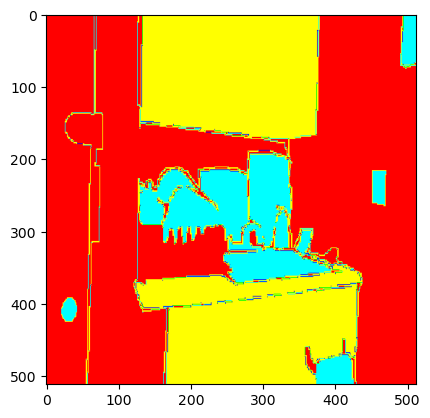

In [3]:
nyu_label = np.load(f"nyuv2_dataset/semantic/{n}.npy").astype(int)
nyu_label = np.vectorize(lambda idx: CLASS_5_TO_IDX_MAP[CLASS_13_TO_5_MAP[CLASS_NAMES_13[idx]]])(nyu_label + 1)
label_vis = class_to_rgb_indoor(nyu_label)
plt.imshow(label_vis)

In [ ]:

# pred_semantic_weights = F.softmax(pred_semantic_weights, dim=1)
# pred_semantic_weights = F.relu(pred_semantic_weights)

# # TODO: clean up
# pred_semantic_13 = torch.zeros(1, 13, 512, 512)
# for i in range(13):
#     indices = (CLASS_40_13_IDX_MAP == i).nonzero()[:, 0]
#     indices = indices[indices > 0] - 1
#     grouped = pred_semantic_weights[:, indices]
#     # pred_semantic_13[:, i] = torch.sum(grouped, dim=1)
#     if grouped.size(1) > 0:
#         pred_semantic_13[:, i], _ = torch.max(grouped, dim=1)

# pred_semantic_13 = F.softmax(pred_semantic_13, dim=1)

# pred_semantic_features = torch.zeros(1, 5, 512, 512)

# for i in range(5):
#     indices = (CLASS_13_5_IDX_MAP == i).nonzero()[:, 0]
#     indices = indices[indices > 0] - 1
#     grouped = pred_semantic_13[:, indices]
#     pred_semantic_features[:, i] = torch.sum(grouped, dim=1)
#     # if grouped.size(1) > 0:
#         # pred_semantic_features[:, i], _ = torch.max(grouped, dim=1)

# # pred_semantic_features = F.softmax(pred_semantic_features, dim=1)
# # pred_semantic_features = F.interpolate(pred_semantic_features, (h, w), mode='bilinear', align_corners=False)
# # pred_semantic_features = pred_semantic_features.to(device)

# pred_semantic = torch.argmax(pred_semantic_features, dim=1)

In [9]:
save_model_path = "TerrainMesh/checkpoints/deeplab/model_best_semantic.tar"
cfg_file = "TerrainMesh/Sensat_basic.yaml"

cfg = get_sensat_cfg()
cfg.merge_from_file(cfg_file)

# Load a trained deeplabv3 2D semantic segmentation model
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model_2dseg = torch.hub.load('pytorch/vision:v0.8.0', 'deeplabv3_resnet50', pretrained=True)
model_2dseg.classifier[4] = nn.Conv2d(256, cfg.MODEL.DEEPLAB.NUM_CLASSES, kernel_size=1, stride=1)
model_2dseg.to(device)
checkpoint = torch.load(save_model_path)
model_2dseg.load_state_dict(checkpoint["model_state_dict"])
model_2dseg.eval()

# The input is an RGB image
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(rgb)
input_img = input_tensor.unsqueeze(0).to(device)
pred_semantic_features = model_2dseg(input_img)["out"]

# print(pred_semantic_features)

pred_semantic = pred_semantic_features.detach().max(dim=1)[1].cpu().numpy()[0,::]
pred_semantic_vis = convert_class_to_rgb_sensat_simplified(pred_semantic)

print(pred_semantic_features.shape)
print(pred_semantic.shape)
print(pred_semantic_features)

# plt.imshow(pred_semantic_vis)

Using cache found in /users/nxu4/.cache/torch/hub/pytorch_vision_v0.8.0
/users/nxu4/.conda/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 5, 512, 512])
(512, 512)
tensor([[[[-6.7973, -6.7973, -6.7973,  ..., -6.5392, -6.5392, -6.5392],
          [-6.7973, -6.7973, -6.7973,  ..., -6.5392, -6.5392, -6.5392],
          [-6.7973, -6.7973, -6.7973,  ..., -6.5392, -6.5392, -6.5392],
          ...,
          [-7.1461, -7.1461, -7.1461,  ..., -6.9960, -6.9960, -6.9960],
          [-7.1461, -7.1461, -7.1461,  ..., -6.9960, -6.9960, -6.9960],
          [-7.1461, -7.1461, -7.1461,  ..., -6.9960, -6.9960, -6.9960]],

         [[-0.7425, -0.7425, -0.7425,  ...,  4.5802,  4.5802,  4.5802],
          [-0.7425, -0.7425, -0.7425,  ...,  4.5802,  4.5802,  4.5802],
          [-0.7425, -0.7425, -0.7425,  ...,  4.5802,  4.5802,  4.5802],
          ...,
          [ 0.1160,  0.1160,  0.1160,  ...,  4.5416,  4.5416,  4.5416],
          [ 0.1160,  0.1160,  0.1160,  ...,  4.5416,  4.5416,  4.5416],
          [ 0.1160,  0.1160,  0.1160,  ...,  4.5416,  4.5416,  4.5416]],

         [[-3.9376, -3.9376, -3.9376,  ..., -4.7322, -4.7322, 

In [27]:
# print(pred_semantic_features.shape)
# print(pred_semantic.shape)
# print(pred_semantic_features)
# print(pred_semantic)

mapping_40_to_13 = torch.randint(0, 13, (40,))
mapping_13_to_5 = torch.randint(0, 5, (13,))

pred_semantic_13 = torch.zeros(1, 13, 512, 512)
for i in range(13):
    indices = (mapping_40_to_13 == i).nonzero()[:, 0]
    pred_semantic_13[:, i] = torch.sum(pred_semantic_weights[:, indices], dim=1)

pred_semantic_features = torch.zeros(1, 5, 512, 512)
for i in range(5):
    indices = (mapping_13_to_5 == i).nonzero()[:, 0]
    pred_semantic_features[:, i] = torch.sum(pred_semantic_13[:, indices], dim=1)

# pred_semantic_features = pred_semantic_features[:,:5,:,:] # TODO: THIS NEEDS REFINEMENT
print(pred_semantic_features.shape)

NameError: name 'pred_semantic_weights' is not defined